# AML Project - Slot Attention Transformer

Model parameters

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as npg


from fullmodel import FullModel
from train import trainmodel
from utils import show_images, plot_results, print_parameters, get_loaders_split


%load_ext autoreload
%autoreload 2

# HYPERPARAMETERS
LEARNING_RATE = 1e-4
EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True
LOAD_MODEL = False
NUM_WORKERS = 0
IMG_DIR = "celldata/01"
MASK_DIR = "celldata/01_ST/SEG"

BATCH_SIZE = 8
NUM_EPOCHS = 40

IMG_SIZE = 128
IMG_C = 1
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
ENCODER_FEATURES = [32, 32, "pool", 64, "pool"]
ENCODER_OUT_CHANNELS = 64
NUM_SLOTS = 40
NUM_HEADS = 8
DIM_HEAD = 32
SLOT_ITERATIONS = 10
HIDDEN_DIM = 32
DECODER_FEATURES = [64, "up", 32, "up", 32]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Initialize data and create dataloaders

In [19]:
import torchvision.transforms as T
from PIL import Image


#hej

train_transform = T.Compose(
    [
        T.ToPILImage(),
        T.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.BILINEAR),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        # T.RandomRotation(degrees=30),
        T.Grayscale(IMG_C),
        T.ToTensor()
    ]
)

val_transform = T.Compose(
    [
        T.ToPILImage(),
        T.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.BILINEAR),
        T.Grayscale(IMG_C),
        T.ToTensor()
    ]
)

train_loader, val_loader = get_loaders_split(
        IMG_DIR,
        MASK_DIR,
        val_split=0.2,
        random_seed=3,
        batch_size=BATCH_SIZE,
        train_transform=train_transform,
        val_transform=val_transform,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )

Total images: 92
Training images: 74
Validation images: 18
Len train_dataset = 74
Len val_dataset = 18


Plot some images and masks

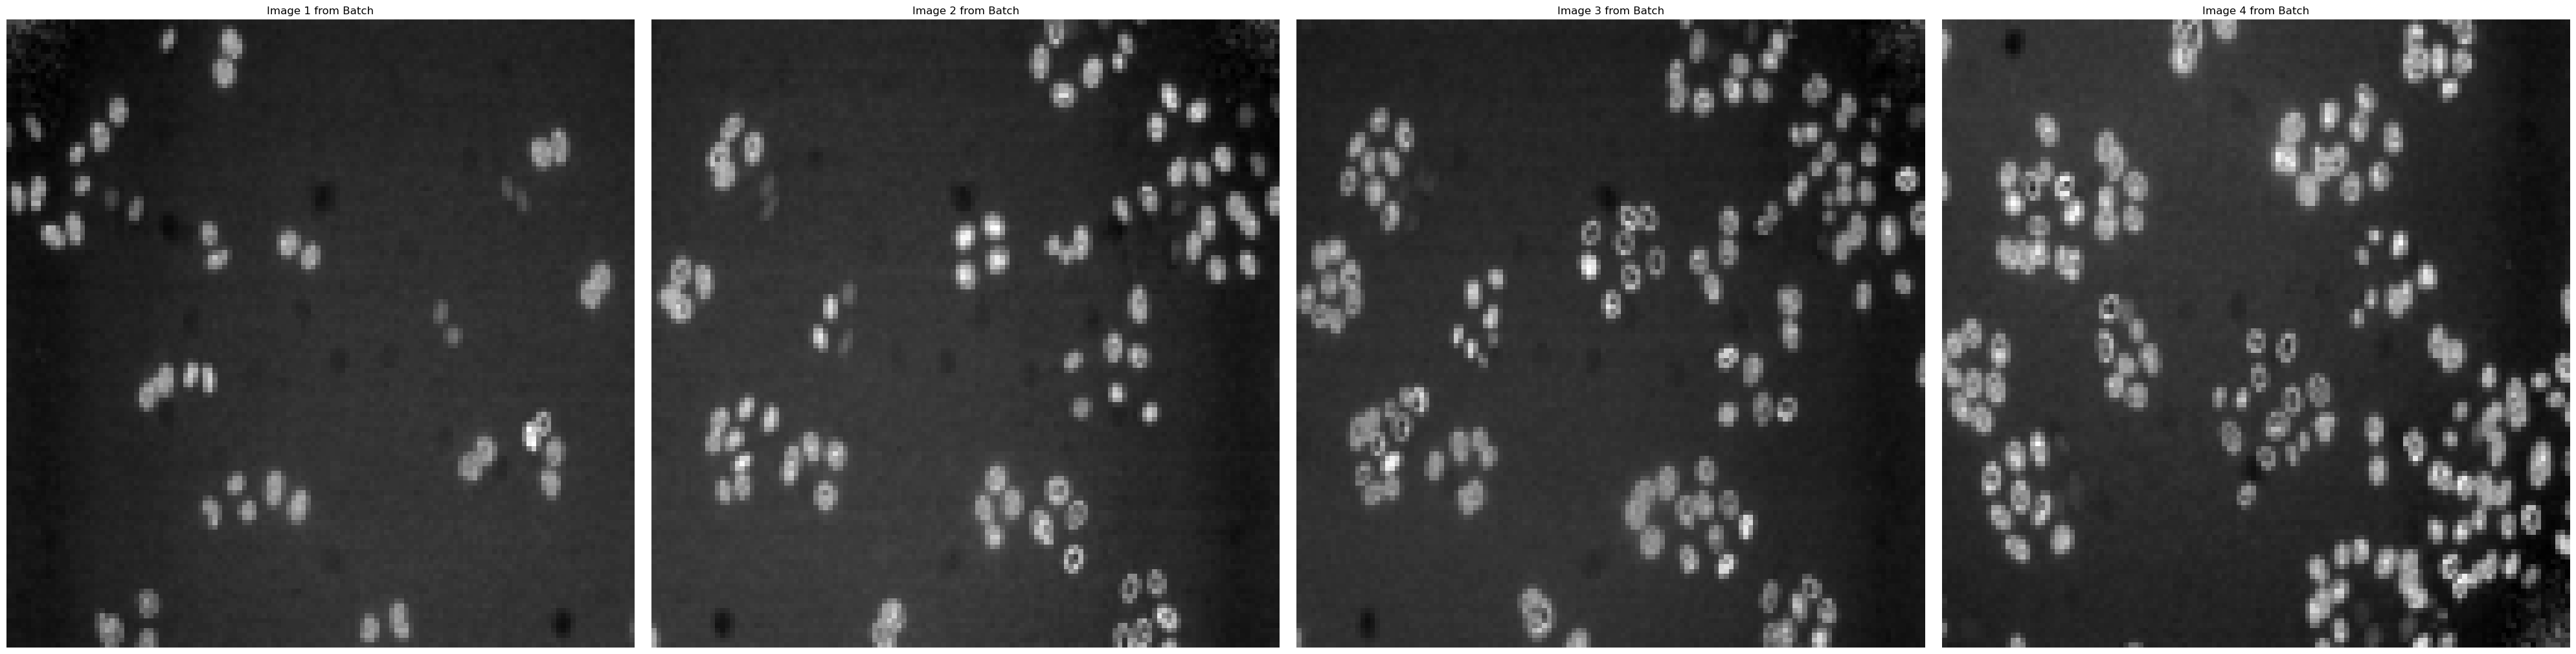

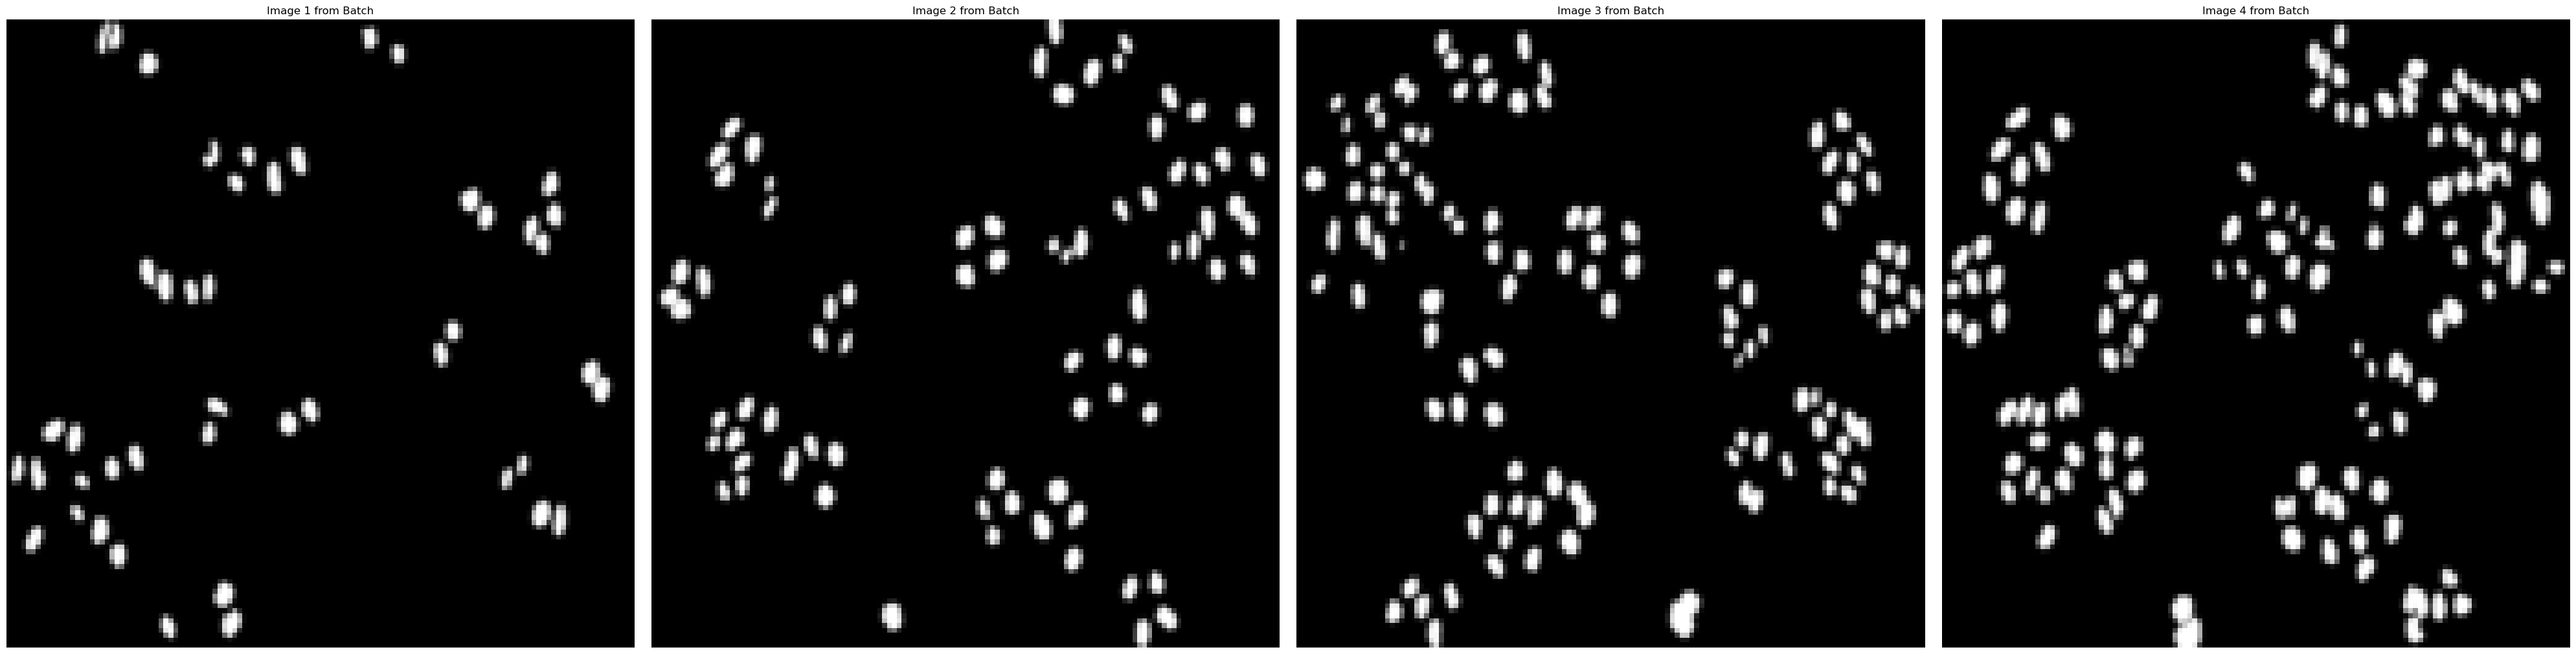

In [22]:
images, masks = next(iter(train_loader))
images = images.to(DEVICE)

num_imgs = 4

show_images(images, num_imgs)
show_images(masks, num_imgs)

## Model

In [5]:
model = FullModel(
    IMG_C,
    IMG_HEIGHT,
    IMG_WIDTH,
    ENCODER_FEATURES,
    ENCODER_OUT_CHANNELS,
    NUM_SLOTS,
    NUM_HEADS,
    DIM_HEAD,
    SLOT_ITERATIONS,
    HIDDEN_DIM,
    DECODER_FEATURES
) .to(DEVICE)

print_parameters(model)

--------Model Parameters--------
Full Model:
---> Trainable parameters: 231.7K

(1) CNN Encoder:
---> Trainable parameters: 65.2K
(2) Positional Encoder:
---> Trainable parameters: 0.0K
(3.1) Multihead Slot Attention:
---> Trainable parameters: 100.2K
(3.2) Adadtive Slot Wrapper:
---> Trainable parameters: 0.1K
(4) CNN Decoder:
---> Trainable parameters: 66.2K

Total: 231.7K trainable paramters, 0 non-trainable parameters


## Training

In [ ]:

loss_fn = nn.MSELoss() # For multiple classes use CrossEntropyLoss (and more out_channels)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

trainmodel(train_loader, val_loader, model, loss_fn, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)

Current epoch: 0 of 40


Current epoch: 1 of 40


Current epoch: 2 of 40


Current epoch: 3 of 40


Current epoch: 4 of 40


Current epoch: 5 of 40


Current epoch: 6 of 40


Current epoch: 7 of 40


Current epoch: 8 of 40


Current epoch: 9 of 40


Current epoch: 10 of 40


Current epoch: 11 of 40


Current epoch: 12 of 40


Current epoch: 13 of 40


Current epoch: 14 of 40


Current epoch: 15 of 40


Current epoch: 16 of 40


Current epoch: 17 of 40


Current epoch: 18 of 40


Current epoch: 19 of 40


Current epoch: 20 of 40


Current epoch: 21 of 40


Current epoch: 22 of 40


Current epoch: 23 of 40


Current epoch: 24 of 40


Current epoch: 25 of 40


Current epoch: 26 of 40


Current epoch: 27 of 40


Current epoch: 28 of 40


Current epoch: 29 of 40


Current epoch: 30 of 40


Current epoch: 31 of 40


Current epoch: 32 of 40


Current epoch: 33 of 40


Current epoch: 34 of 40


Current epoch: 35 of 40


Current epoch: 36 of 40


Current epoch: 37 of 40


Current epoch: 38 of 40


Current epoch: 39 of 40


## Plot results

In [19]:
# x_out, attn_maps, keep_slots = model(images)

# plot_results(img_batch=images, mask_batch=masks, attn_maps=attn_maps, keep_slots=keep_slots, y_batch=x_out, num_imgs=4)